## Quantum Annealing for the Nuclear Hamiltonian

### Overview on the Quantum Annealing cki

#### Imports

In [ ]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

file_name='data/cki'
SPS=SingleParticleState(file_name=file_name)

In [2]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

#### $J^2$ Matrix

In [3]:
matrix_j,energies=get_twobody_nuclearshell_model(file_name='data/j2.int')

mij_matrix=np.zeros((energies.shape[0],energies.shape[0]))
diag_j=np.zeros(energies.shape[0])
diag_m=np.zeros(energies.shape[0])
label=[]
for i in range(energies.shape[0]):
    n,l,j,m,t,tz=SPS.state_encoding[i]
    diag_j[i]=j*(j+1)
    diag_m[i]=m
    label.append((j,m,tz))
    for r in range(energies.shape[0]):
        n,l,j,mr,t,tz=SPS.state_encoding[r]
        mij_matrix[i,r]=m-mr


Joperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Joperator.get_twobody_interaction(twobody_dict=matrix_j)
Joperator.get_external_potential(diag_j)
Joperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Moperator.get_external_potential(diag_m)
Moperator.get_hamiltonian()




Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.91it/s]
592it [00:01, 392.60it/s]


#### Define the initial Hamiltonian

In [90]:

t=3.
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a,size_a))
for i in range(size_a):
    for j in range(size_a):
        (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
        (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
        if np.isclose(mi,-mj) and np.isclose(ni,nj):
            kinetic_term[(i,j)]=t #np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,i)]=t #np.abs(mi-mj)#+np.abs(ji-jj)
            
            adj_matrix[i,j]=t#np.abs(mi-mj)#+np.abs(ji-jj)
            if size_b==size_a:    
                kinetic_term[(size_a +i,size_a+j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                kinetic_term[(size_a+j,size_a +i)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
external_field=np.zeros(size_a+size_b)
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    external_field[i]=0.
    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

egs,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)
print(egs)

[-18.]


#### Initial Hamiltonian with M conservation

otherwise= 0.5 0.5
0.5 1.5
otherwise= 0.5 0.5
0.5 1.5
1.5 0.5
1.5 0.5
otherwise= 0.5 0.5
0.5 1.5
otherwise= 0.5 0.5
0.5 1.5
1.5 0.5
1.5 0.5
total_m= [0.]
total J^2= [[2.05835921]]


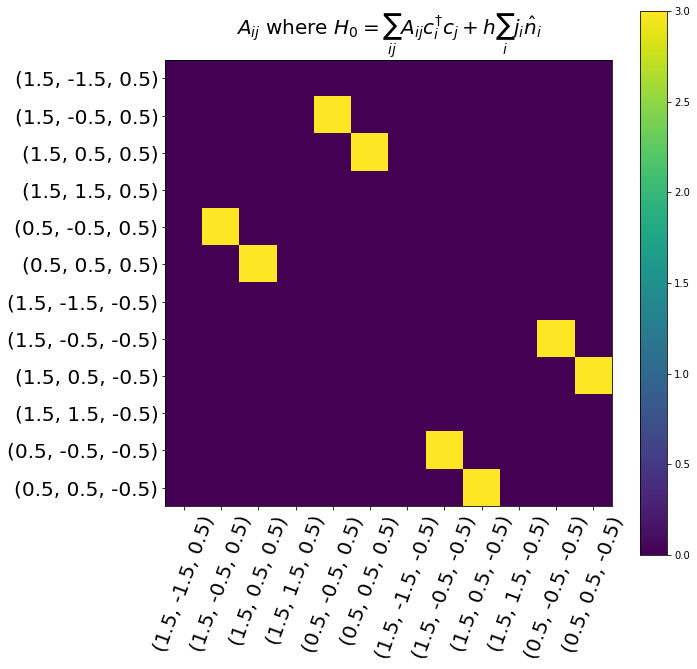

energies= [-1.41640786]
m value= 


In [5]:

t=3.
w=3.
h=3
g=0.
r=0
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]




mj_list=[]
for j in j_values:
    m_values=-2*j+2*np.arange(0,int(2*j)+1)
    
    m_values=m_values[m_values>0.]
    for m in m_values:
        mj_list.append((m/2,j,1))


# for tzi in [-1/2,1/2]:
    
#     for tupi in mj_list:
#         for tupj in mj_list:
#             mi,ji=tupi
#             mj,jj=tupj
            
#             i=SPS.get_index((1,0,ji,mi,1/2,tzi))
#             k=SPS.get_index((1,0,ji,-1*mi,1/2,tzi))
#             j=SPS.get_index((1,0,jj,mj,1/2,tzi))
#             l=SPS.get_index((1,0,jj,-1*mj,1/2,tzi))
#             kinetic_term[(i,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#             adj_matrix[i,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
#             kinetic_term[(i,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#             adj_matrix[i,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
#             kinetic_term[(k,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#             adj_matrix[k,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
#             kinetic_term[(k,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#             adj_matrix[k,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
for tzi in [-1/2,1/2]:
    
    for f,tupi in enumerate(mj_list):
        mi,ji,ni=tupi
        #mj,jj,nj=mj_list[(f+1)% len(mj_list)]
        for tupj in mj_list:
            mj,jj,nj=tupj
            if mi!=mj:
                print(mi,mj)
                continue
            if ji==jj:
                continue
            print('otherwise=',mi,mj)
            #if ni==nj:
            i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
            k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
            j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
            l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
            kinetic_term[(i,j)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,i)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,i]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(i,l)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,l]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(l,i)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,i]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,j)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,j]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,k)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,k]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,l)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,l]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(l,k)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,k]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
        


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    external_field[i]=h*(ji)
    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

einitial,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix)
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.show()

print('energies=',einitial)
#print(InitialHamiltonian.hamiltonian)
print('m value=',Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian)

3.0 -3.0
total_m= -2.220446049250313e-16
total J^2= 2.6286796564403625


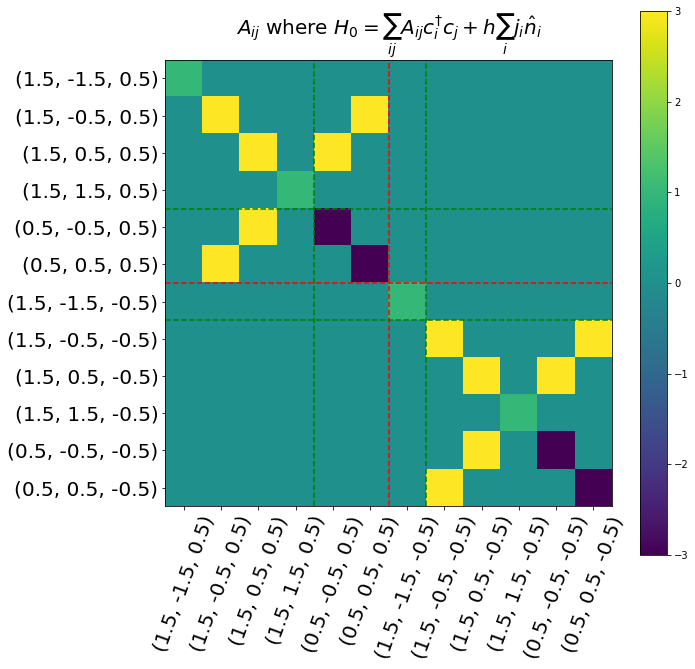

-16.970562748477125
m value=   (0, 4)	-3.0
  (0, 60)	-3.0
  (1, 3)	3.0
  (1, 61)	-3.0
  (2, 62)	-3.0
  (3, 1)	-3.0
  (3, 63)	-3.0
  (4, 0)	3.0
  (4, 64)	-3.0
  (5, 7)	3.0
  (5, 11)	3.0
  (5, 65)	-3.0
  (6, 13)	3.0
  (6, 66)	-3.0
  (7, 5)	-3.0
  (7, 14)	3.0
  (7, 67)	-3.0
  (8, 68)	-3.0
  (9, 12)	-3.0
  (9, 69)	-3.0
  (10, 70)	-3.0
  (11, 5)	-3.0
  (11, 14)	3.0
  (11, 71)	-3.0
  (12, 9)	3.0
  :	:
  (217, 112)	-3.0
  (217, 172)	-3.0
  (217, 215)	-3.0
  (217, 224)	3.0
  (218, 113)	-3.0
  (218, 173)	-3.0
  (219, 114)	-3.0
  (219, 174)	-3.0
  (219, 222)	-3.0
  (220, 115)	-3.0
  (220, 175)	-3.0
  (221, 116)	-3.0
  (221, 176)	-3.0
  (221, 215)	-3.0
  (221, 224)	3.0
  (222, 117)	-3.0
  (222, 177)	-3.0
  (222, 219)	3.0
  (223, 118)	-3.0
  (223, 178)	-3.0
  (223, 216)	-3.0
  (224, 119)	-3.0
  (224, 179)	-3.0
  (224, 217)	-3.0
  (224, 221)	-3.0


In [118]:
omega=3
omega_b=3
omega_c=1

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]

print(t,w)


mj_list=[]
for a in range(energies.shape[0]):
    for b in range(energies.shape[0]):
        (na,la,ja,ma,ta,tza)=SPS.state_encoding[a]
        (nb,lb,jb,mb,tb,tzb)=SPS.state_encoding[b]
        
        if ja==1.5 and ma==0.5 and jb==0.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega
        
        if ja==0.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_b
            kinetic_term[(b,a)]=omega_b
            adj_matrix[a,b]=omega_b
            adj_matrix[b,a]=omega_b
        
        # if ja==1.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega_c
        #     kinetic_term[(b,a)]=omega_c
        #     adj_matrix[a,b]=omega_c
        #     adj_matrix[b,a]=omega_c


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    if ji==1.5 and (mi)==0.5:
        external_field[i]=omega
    if ji==0.5 and (mi)==-0.5:
        external_field[i]=omega
        
    if ji==1.5 and (mi)==-0.5:
        external_field[i]=omega_b
    if ji==0.5 and (mi)==0.5:
        external_field[i]=omega_b
        
    if ji==1.5 and mi==1.5:
        external_field[i]=omega_c
        
    if ji==1.5 and mi==-1.5:
        external_field[i]=omega_c
        
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)

#print(InitialHamiltonian.hamiltonian)
print('m value=',Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian)

#### Intermediate Hamiltonian

In [110]:


IntermediateHamiltonian = FermiHubbardHamiltonian(
    size_a=size_a, size_b=size_b, nparticles_a=nparticles_a, nparticles_b=nparticles_b
)

kinetic_term: Dict = {}
adj_matrix = np.zeros((size_a+size_b, size_a+size_b))
for tzi in [-1/2,1/2]:
    
    for f,tupi in enumerate(mj_list):
        mi,ji,ni=tupi
        mj,jj,nj=mj_list[(f+1)% len(mj_list)]
        
        #if ni==nj:
        i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
        k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
        kinetic_term[(i,k)]=-1*(h*(ji)+g*np.abs(mi))/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[i,k]=-1*(h*(ji)+g*np.abs(mi))/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(k,i)]=-1*(h*(ji)+g*np.abs(mi))/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[k,i]=-1*(h*(ji)+g*np.abs(mi))/2#np.abs(mi-mj)#+np.abs(ji-jj)



    # external_field[i] = SPS.energies[i]

IntermediateHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
#IntermediateHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix_intermediate)
IntermediateHamiltonian.get_hamiltonian()

print(IntermediateHamiltonian.hamiltonian-IntermediateHamiltonian.hamiltonian.conjugate().transpose())
eng, _ = IntermediateHamiltonian.get_spectrum(n_states=1)
print(eng)
print(IntermediateHamiltonian.hamiltonian)

AttributeError: 'float' object has no attribute 'copy'

#### Define the target Hamiltonian

In [6]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

iso_dict={-0.5:'n',0.5:'p'}
values=np.asarray(list(twobody_matrix.values()))
print(np.average(np.abs(values)))
for key in twobody_matrix.keys():
    i,j,k,l=key
    (n,_,ja,ma,t,tza)=SPS.state_encoding[i]
    (n,_,jb,mb,t,tzb)=SPS.state_encoding[j]
    (n,_,jc,mc,t,tzc)=SPS.state_encoding[k]
    (n,_,jd,md,t,tzd)=SPS.state_encoding[l]

    print(ja,ma,iso_dict[tza]+'+'+iso_dict[tzb],jb,mb,'-->',jc,mc,iso_dict[tzc]+'+'+iso_dict[tzd],jd,md)
    print('cross section=',twobody_matrix[key],'\n')
    
    
    
    
#%% initialize the FH Hamiltonian



Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.97it/s]


1.4069726715197104
1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -1.5 p+p 1.5 -0.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -0.5 p+p 1.5 -1.5
cross section= 0.6490000000000002 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 1.5 -0.5
cross section= 0.6490000000000002 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -0.5 p+p 1.5 -1.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -1.5 p+p 0.5 -0.5
cross section= 2.2055000000000007 

1.5 -1.5 p+p 1.5 -0.5 --> 0.5 -0.5 p+p 1.5 -1.5
cross section= -2.2055000000000007 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 0.5 -0.5
cross section= -2.2055000000000007 

1.5 -0.5 p+p 1.5 -1.5 --> 0.5 -0.5 p+p 1.5 -1.5
cross section= 2.2055000000000007 

1.5 -1.5 p+p 1.5 0.5 --> 1.5 -1.5 p+p 1.5 0.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 0.5 --> 1.5 0.5 p+p 1.5 -1.5
cross section= 0.6490000000000002 

1.5 0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 1.5 0.5
cross section= 0.6490000000000002 

1.5 0.5 p+p 1.5 -1.5 --> 1.5 0.5 p+p 1.5 -1.5
cross sectio

In [8]:
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.get_hamiltonian()

egs,psi0=TargetHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=TargetHamiltonian.basis))










j2=psi0.transpose().dot(Joperator.hamiltonian.dot(psi0))
jvalue=0.5 * ( np.sqrt(4.0 * j2 + 1) - 1 )

print('total_J=',jvalue)
print('m value=',Moperator.hamiltonian @ TargetHamiltonian.hamiltonian- TargetHamiltonian.hamiltonian @ Moperator.hamiltonian)


size= 12 6


0it [00:00, ?it/s]

1424it [00:03, 404.64it/s]


[-30.29539461]
total_m= [-1.38777878e-17]
total_J= [[5.88418203e-15]]
m value= 


#### Create the interpolate Hamiltonian and Perform the spectrum

100%|██████████| 100/100 [00:02<00:00, 42.22it/s]


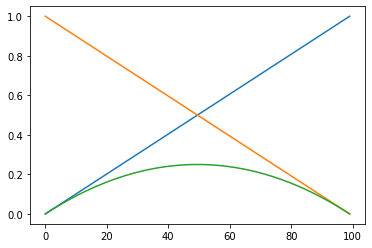

In [9]:
ngrid=100
nlevels=10
lambd=np.linspace(0,1.,ngrid)

spectrum=np.zeros((nlevels,ngrid))
psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
j_values=np.zeros_like(spectrum)
m_values = np.zeros_like(spectrum)
comm=np.zeros_like(spectrum)
plt.plot(lambd)
plt.plot(1-lambd)
plt.plot(lambd*(1-lambd))

for i in trange(ngrid):

    ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

    values,psis=eigsh(ham,k=nlevels,which='SA')
    for a in range(psis.shape[-1]):    
        j_values[a,i]=psis[:,a].conjugate().transpose() @ Joperator.hamiltonian @ psis[:,a]
        m_values[a, i] = SPS.compute_m_exp_value(psi=psis[:,a],basis=InitialHamiltonian.basis)
        comm[a,i]=(psis[:,a].conjugate().transpose() @ Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian @ psis[:,a])[0]

    spectrum[:,i]=values
    psi_spectrum=psis

Spectrum

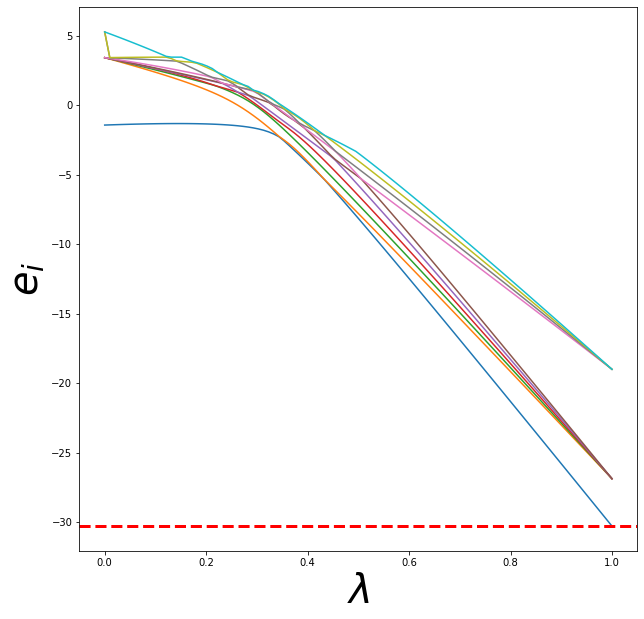

0.0002447418715292704
-30.295394613605612


In [10]:
plt.figure(figsize=(10,10))
for i in range(nlevels):
    plt.plot(lambd,spectrum[i])
# plt.xlim([0.9,1])
plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)
plt.savefig('images/fig_1')
plt.show()


t_critic=np.argmax(spectrum[0])
gap=np.min(np.abs(spectrum[1,:]-spectrum[0,:]))
print((gap**2))
print(spectrum[0,-1])

#### Expectation values

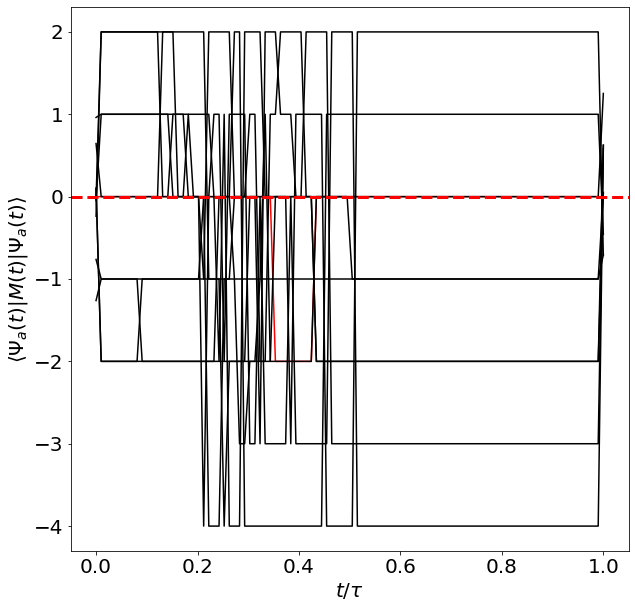

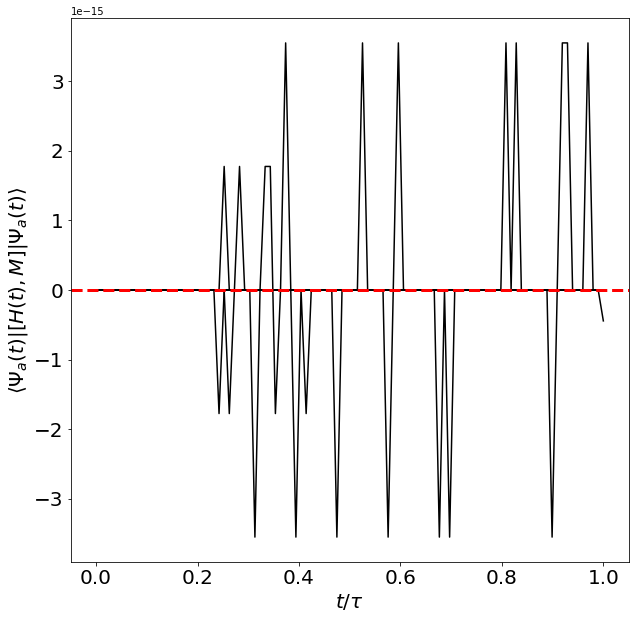

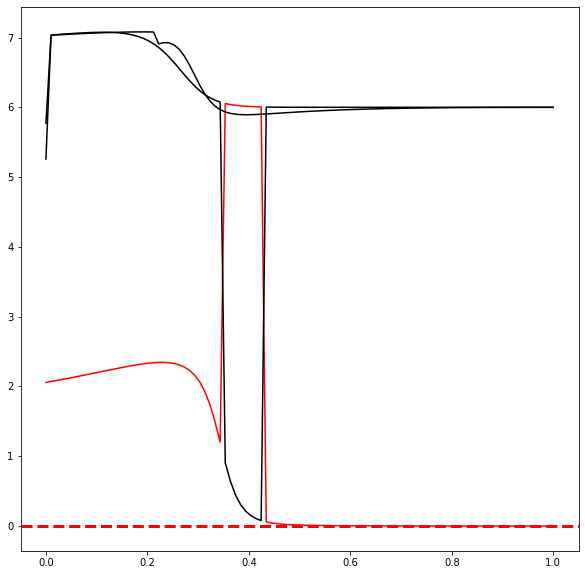

In [11]:



plt.figure(figsize=(10, 10))
plt.plot(lambd,m_values[0],color='red')
for i in range(1,10):
    plt.plot(lambd, m_values[i],color='black')
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$t/\tau$',fontsize=20)
plt.ylabel(r'$\langle \Psi_a (t) | M(t) | \Psi_a (t) \rangle$',fontsize=20)
plt.tick_params(which='major',labelsize=20)

# plt.xlim([0.9,1])
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(lambd,comm[0],color='red')
for i in range(1,10):
    plt.plot(lambd, comm[i],color='black')

plt.xlabel(r'$t/\tau$',fontsize=20)
plt.ylabel(r'$\langle \Psi_a (t) | [H(t),M] |\Psi_a (t) \rangle$',fontsize=20)
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
plt.tick_params(which='major',labelsize=20)

# plt.xlim([0.9,1])
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(lambd,j_values[0],color='red')
for i in range(1,3):
    plt.plot(lambd, j_values[i],color='black')
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.show()

#### Simulation of the Quantum Annealing

In [13]:
nstep =500
tf = 10
nlevels=10
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
probabilities=np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=nlevels, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:,0]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:,0])
            count=count+1
        
        probabilities[j,i]=(
                psis[:, j].conjugate().transpose() @ psi[:,0]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:,0])

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)
print(eng_t.shape)

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_544600/4152542456.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  probabilities[j,i]=(
100%|██████████| 500/500 [00:03<00:00, 126.46it/s]

[[0.18570861]]
(0.4121940099116952+0j)
(500, 1, 1)


(500, 1, 1)
(500,)
[1.31890278e-31 1.27388045e-08 5.41859768e-08 1.29063829e-07
 2.41790741e-07 3.96305196e-07 5.95893534e-07 8.43029377e-07
 1.13923250e-06 1.48495438e-06 1.87949663e-06 2.32096721e-06
 2.80627772e-06 3.33118331e-06 3.89036475e-06 4.47755060e-06
 5.08567549e-06 5.70706926e-06 6.33367019e-06 6.95725526e-06
 7.56967925e-06 8.16311514e-06 8.73028792e-06 9.26469514e-06
 9.76080808e-06 1.02142486e-05 1.06219382e-05 1.09822166e-05
 1.12949296e-05 1.15614847e-05 1.17848773e-05 1.19696881e-05
 1.21220544e-05 1.22496176e-05 1.23614509e-05 1.24679680e-05
 1.25808170e-05 1.27127605e-05 1.28775438e-05 1.30897539e-05
 1.33646679e-05 1.37180947e-05 1.41662084e-05 1.47253762e-05
 1.54119815e-05 1.62422436e-05 1.72320370e-05 1.83967131e-05
 1.97509276e-05 2.13084784e-05 2.30821580e-05 2.50836272e-05
 2.73233135e-05 2.98103423e-05 3.25525039e-05 3.55562630e-05
 3.88268136e-05 4.23681838e-05 4.61833902e-05 5.02746460e-05
 5.46436179e-05 5.92917324e-05 6.42205259e-05 1.31247355e-31
 1.20

<Figure size 720x720 with 0 Axes>

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


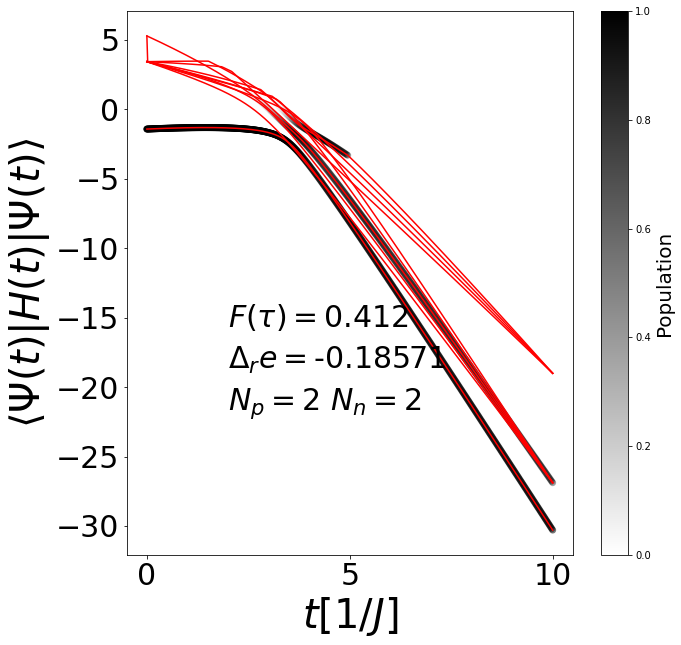

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


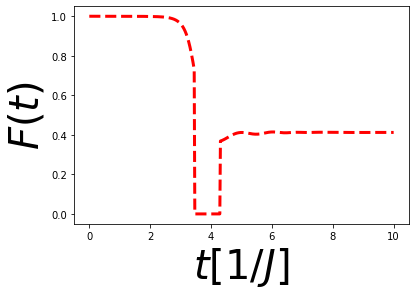

In [23]:
levels_studied=10
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('transparency_to_black', [(0, 0, 0, 0), (0, 0, 0, 1)])
fig=plt.figure(figsize=(10,10))

print(eng_t.shape)
print(fidelity_t.shape)
plt.figure(figsize=(10, 10))
print(probabilities[-1])
tot_scatters=[]

probs=probabilities[:levels_studied]

print(probabilities[1])
norm = plt.Normalize(probabilities.min(), probabilities.max())
for i in range(0,levels_studied):
    plt.plot(time, spectrum[i],color='red')

for i in range(0,levels_studied):
    plt.scatter(time, spectrum[i],c=probabilities[i],cmap=cmap,norm=norm)

#gs_scatter=plt.scatter(time,eng_t[:,0,0],c=probabilities[0,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)

colorbar=plt.colorbar()
colorbar.set_label('Population',fontsize=20)

# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=tf*1/5,y=eng_t[-1,0,0]+9,s=r'$F(\tau)=$'+f'{fidelity.real:.3f}',fontsize=30)
plt.text(x=tf * 1 / 5, y=eng_t[-1,0,0]+6, s=r"$\Delta_r e=$" + f"{(eng_t[-1,0,0].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=tf * 1 / 5,
    y=eng_t[-1,0,0]+3,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.show()



plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)

plt.show()

#### Fidelity vs $\tau$

In [26]:
tfs=[1,2,4,8,16,32,64]
relative_eng=[]
fidelities=[]
nstep=200

for tf in tfs:
    time = np.linspace(0.0, tf, nstep)
    psi = psi_initial
    dt=time[1]-time[0]
    eng_t=[]
    variance_t=[]
    fidelity_t=[]
    lambd=1-time/tf
    for i in trange(nstep):

        time_hamiltonian = (
            InitialHamiltonian.hamiltonian * ( lambd[i])
            + TargetHamiltonian.hamiltonian * (1-lambd[i])
        ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
        values, psis = eigsh(time_hamiltonian, k=nlevels, which="SA")
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

        e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
        e_square_ave = (
            psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
        )
        eng_t.append(e_ave)
        variance_t.append(e_square_ave-e_ave**2)
        spectrum[:, i] = values

        degenerate_fidelity=0.
        count=0
        for j in range(values.shape[0]):
            if np.isclose(values[j],values[0]):
                degenerate_fidelity += (
                    psis[:, j].conjugate().transpose() @ psi[:, 0]
                ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:, 0])
                count=count+1
            
    

        fidelity=degenerate_fidelity        
    print(fidelity)    
    eng_t=np.asarray(eng_t)
    relative_eng.append(np.abs((egs-eng_t[-1])/egs)[0,0])
    fidelities.append(fidelity)
    


100%|██████████| 200/200 [00:01<00:00, 128.68it/s]


(0.02382910095792441+0j)


100%|██████████| 200/200 [00:01<00:00, 131.73it/s]


(0.0651781381619489+0j)


100%|██████████| 200/200 [00:01<00:00, 120.77it/s]


(0.14971533549761257+0j)


100%|██████████| 200/200 [00:01<00:00, 129.55it/s]


(0.3305909313708165+0j)


100%|██████████| 200/200 [00:01<00:00, 127.32it/s]


(0.6138145442005591+0j)


100%|██████████| 200/200 [00:01<00:00, 119.63it/s]


(0.8826660808437248+0j)


100%|██████████| 200/200 [00:01<00:00, 114.18it/s]

(0.9892984490066893+0j)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


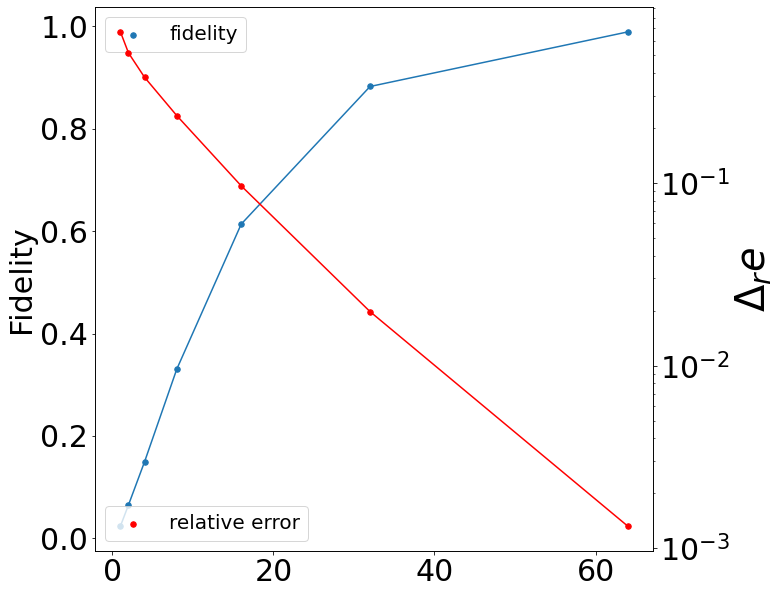

In [25]:
fig,ax=plt.subplots(figsize=(10,10))

ax2=ax.twinx()
ax.plot(tfs,fidelities)
ax.scatter(tfs,fidelities,s=30,label='fidelity')
ax.tick_params(which='major',labelsize=30)
ax2.plot(tfs,relative_eng,color='red')
ax2.scatter(tfs,relative_eng,s=30,color='red',label='relative error')
ax2.legend(fontsize=20,loc='lower left')
ax.legend(fontsize=20)
ax2.semilogy()

plt.xlabel(r'$\tau$',fontsize=30)
ax.set_ylabel('Fidelity',fontsize=30)
ax2.set_ylabel(r'$\Delta_r e$',fontsize=40)

ax2.tick_params(which='major',labelsize=30)
plt.show()

### Overview on the Quantum Annealing usdb

#### Imports

In [1]:

from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy

file_name='data/usdb.nat'
SPS=SingleParticleState(file_name=file_name)
energies=SPS.energies

In [73]:
nparticles_a=4
nparticles_b=0

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

#### $J^2$ Matrix

In [74]:
matrix_j,_=get_twobody_nuclearshell_model(file_name='data/j2.int')

energies=SPS.energies

diag_j=np.zeros(energies.shape[0])
diag_m=np.zeros(energies.shape[0])
label=[]
for i in range(energies.shape[0]):
    n,l,j,m,t,tz=SPS.state_encoding[i]
    label.append((j,m,tz))
    diag_j[i]=j*(j+1)
    diag_m[i]=m

Joperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Joperator.get_twobody_interaction(twobody_dict=matrix_j)
Joperator.get_external_potential(diag_j)
Joperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Moperator.get_external_potential(diag_m)
Moperator.get_hamiltonian()




Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.15it/s]
592it [00:03, 175.27it/s]


#### Define the initial Hamiltonian

In [110]:
t=3.
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a,size_a))

for i in range(size_a):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    
    for j in range(size_a):
        (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
        if np.isclose(mi,-mj) and np.isclose(ni,nj):
            kinetic_term[(i,j)]=t #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=t#np.abs(mi-mj)#+np.abs(ji-jj)
            if size_b==size_a:    
                kinetic_term[(size_a +i,size_a+j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                
external_field=np.zeros(size_a+size_b)
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    external_field[i]=0.
    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

egs,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)
print(egs)

[-18.]


#### Initial Hamiltonian with M conservation

[(2, 0, 2.5, -2.5, 0.5, 0.5), (2, 0, 2.5, -1.5, 0.5, 0.5), (2, 0, 2.5, -0.5, 0.5, 0.5), (2, 0, 2.5, 0.5, 0.5, 0.5), (2, 0, 2.5, 1.5, 0.5, 0.5), (2, 0, 2.5, 2.5, 0.5, 0.5), (1, 0, 0.5, -0.5, 0.5, 0.5), (1, 0, 0.5, 0.5, 0.5, 0.5), (2, 0, 1.5, -1.5, 0.5, 0.5), (2, 0, 1.5, -0.5, 0.5, 0.5), (2, 0, 1.5, 0.5, 0.5, 0.5), (2, 0, 1.5, 1.5, 0.5, 0.5), (2, 0, 2.5, -2.5, 0.5, -0.5), (2, 0, 2.5, -1.5, 0.5, -0.5), (2, 0, 2.5, -0.5, 0.5, -0.5), (2, 0, 2.5, 0.5, 0.5, -0.5), (2, 0, 2.5, 1.5, 0.5, -0.5), (2, 0, 2.5, 2.5, 0.5, -0.5), (1, 0, 0.5, -0.5, 0.5, -0.5), (1, 0, 0.5, 0.5, 0.5, -0.5), (2, 0, 1.5, -1.5, 0.5, -0.5), (2, 0, 1.5, -0.5, 0.5, -0.5), (2, 0, 1.5, 0.5, 0.5, -0.5), (2, 0, 1.5, 1.5, 0.5, -0.5)]


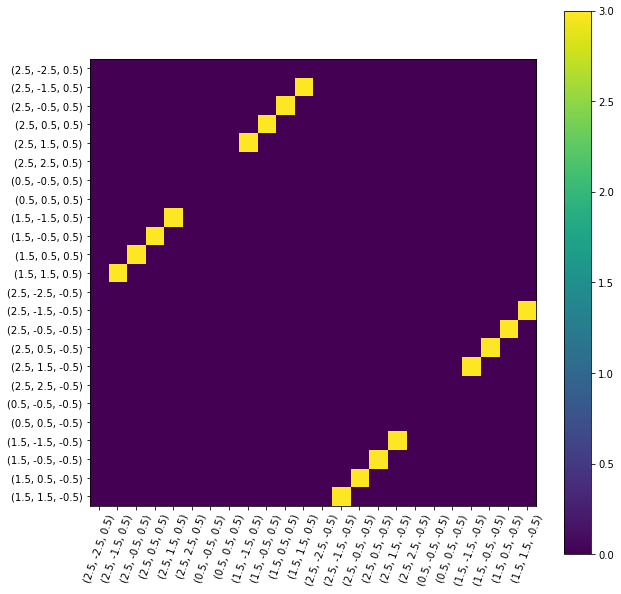

In [75]:

t=3
w=-3
h=3.
g=0.
r=0.
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
print(SPS.state_encoding)
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))


#usdb
j_values=[1/2,3/2,5/2]
n_values=[1,2,2]

mj_list=[]
for q,j in enumerate(j_values):
    m_values=-2*j+2*np.arange(0,int(2*j)+1)
    
    m_values=m_values[m_values>0.]
    for m in m_values:
        mj_list.append((m/2,j,n_values[q]))


# for tzi in [1/2]:
    
#     for tupi in mj_list:
#         for tupj in mj_list:
#             mi,ji,ni=tupi
#             mj,jj,nj=tupj
            
#             if ni==nj:
#                 i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
#                 k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
#                 j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
#                 l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
#                 kinetic_term[(i,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#                 adj_matrix[i,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
#                 kinetic_term[(i,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#                 adj_matrix[i,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
#                 kinetic_term[(k,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#                 adj_matrix[k,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
#                 kinetic_term[(k,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#                 adj_matrix[k,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
for tzi in [1/2,-1/2]:
    
    for f,tupi in enumerate(mj_list):
        mi,ji,ni=tupi
        #mj,jj,nj=mj_list[(f+1)% len(mj_list)]
        for tupj in mj_list:
            mj,jj,nj=tupj
            if mi!=mj:
                continue
            if ji==jj:
                continue
            
            #if (ji==1.5 and np.abs(mi)==0.5 and np.abs(mj)==0.5 and jj==2.5) or (ji==2.5 and np.abs(mi)==0.5 and np.abs(mj)==0.5 and jj==1.5):
            #   continue
            
            #if (ji==1.5 and np.abs(mi)==1.5 and np.abs(mj)==1.5 and jj==2.5) or (ji==2.5 and np.abs(mi)==1.5 and np.abs(mj)==1.5 and jj==1.5):
            #   continue
            
            
            if (ji==1.5 and np.abs(mi)==0.5 and np.abs(mj)==0.5 and jj==0.5) or (ji==0.5 and np.abs(mi)==0.5 and np.abs(mj)==0.5 and jj==1.5):
                continue
            
            if (ji==2.5 and np.abs(mi)==0.5 and np.abs(mj)==0.5 and jj==0.5) or (ji==0.5 and np.abs(mi)==0.5 and np.abs(mj)==0.5 and jj==2.5):
               continue
           
            # if (ji==1.5 and jj==0.5) or (jj==1.5 and ji==0.5):
            #     t=4
            #     w=-4
            # else:
            #     t=2
            #     w=-2
            
            
            
            #if ni==nj:
            i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
            k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
            j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
            l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
            kinetic_term[(i,j)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,i)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,i]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(i,l)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,l]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(l,i)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,i]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,j)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,j]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,k)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,k]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,l)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,l]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(l,k)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,k]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        




# # for i in range(size_a):
# #     for j in range(size_a):
# #         (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
# #         (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
# #         if np.isclose(mi,-mj) and np.isclose(ni,nj):
            
# #             if size_b==size_a:    
# #                 kinetic_term[(size_a +i,size_a+j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                
external_field=np.zeros(size_a+size_b)
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    external_field[i]=0#h*(ji)+g*np.abs(mi)+r*ni
    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

einitial,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)

plt.figure(figsize=(10,10))
plt.imshow(adj_matrix)
plt.colorbar()
plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.yticks(np.arange(energies.shape[0]),label)

plt.savefig('images/na20_topology')
plt.show()

total_m= 0.770987970036071
total J^2= 14.886779244338328


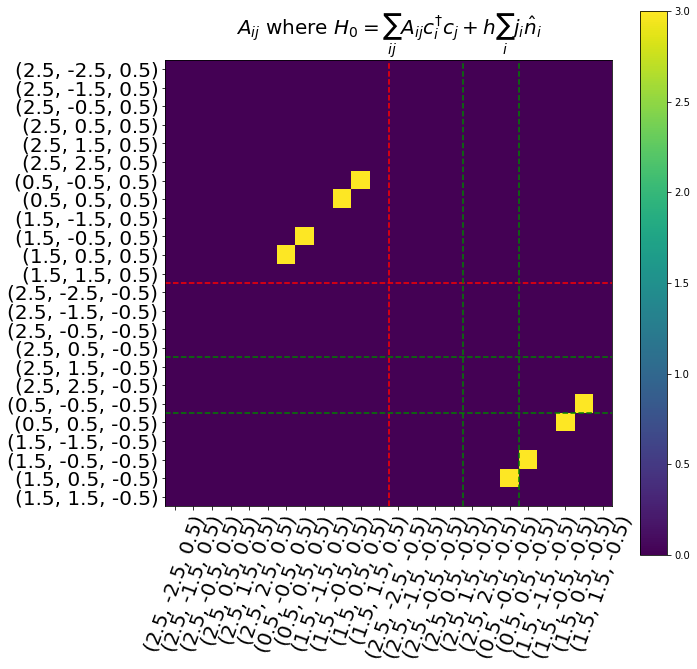

-6.000000000000009


In [101]:
omega=0.
omega_b=0
omega_c=3

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]


mj_list=[]
for a in range(energies.shape[0]):
    for b in range(energies.shape[0]):
        (na,la,ja,ma,ta,tza)=SPS.state_encoding[a]
        (nb,lb,jb,mb,tb,tzb)=SPS.state_encoding[b]
        
        # if ja==2.5 and (ma)==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega
        #     kinetic_term[(b,a)]=omega
        #     adj_matrix[a,b]=omega
        #     adj_matrix[b,a]=omega
        
        if ja==2.5 and (ma)==1.5 and jb==1.5 and mb==-1.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega
            
        # if ja==1.5 and (ma)==0.5 and jb==2.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega
        #     kinetic_term[(b,a)]=omega
        #     adj_matrix[a,b]=omega
        #     adj_matrix[b,a]=omega
        
        if ja==1.5 and (ma)==1.5 and jb==2.5 and mb==-1.5 and tza==tzb:
            kinetic_term[(a,b)]=omega
            kinetic_term[(b,a)]=omega
            adj_matrix[a,b]=omega
            adj_matrix[b,a]=omega
            
        if ja==1.5 and (ma)==0.5 and jb==0.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_c
            kinetic_term[(b,a)]=omega_c
            adj_matrix[a,b]=omega_c
            adj_matrix[b,a]=omega_c
        
        if ja==0.5 and (ma)==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
            kinetic_term[(a,b)]=omega_c
            kinetic_term[(b,a)]=omega_c
            adj_matrix[a,b]=omega_c
            adj_matrix[b,a]=omega_c
        
        
        # if ja==1.5 and ma==0.5 and jb==1.5 and mb==-0.5 and tza==tzb:
        #     kinetic_term[(a,b)]=omega_c
        #     kinetic_term[(b,a)]=omega_c
        #     adj_matrix[a,b]=omega_c
        #     adj_matrix[b,a]=omega_c


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    if ji==1.5 and (mi)==0.5:
        external_field[i]=0
    if ji==0.5 and (mi)==-0.5:
        external_field[i]=0
        
    if ji==1.5 and (mi)==-0.5:
        external_field[i]=0
    if ji==0.5 and (mi)==0.5:
        external_field[i]=0
        
    if ji==1.5 and mi==1.5:
        external_field[i]=-omega/2
        
    if ji==1.5 and mi==-1.5:
        external_field[i]=-omega/2
        
    if ji==2.5 and mi==1.5:
        external_field[i]=omega/2
        
    if ji==2.5 and mi==-1.5:
        external_field[i]=omega/2
    
    if ji==2.5 and mi==0.5:
        external_field[i]=omega/4
        
    if ji==2.5 and mi==-0.5:
        external_field[i]=omega/4
    
    

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix+np.eye(energies.shape[0])*external_field[None,:])
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

print(einitial)



#### Intermediate Hamiltonian

In [59]:
t=-9

IntermediateHamiltonian = FermiHubbardHamiltonian(
    size_a=size_a, size_b=size_b, nparticles_a=nparticles_a, nparticles_b=nparticles_b
)

kinetic_term: Dict = {}
adj_matrix = np.zeros((size_a, size_a))
for i in range(size_a):
    # kinetic_term[(i, (i+1)%size_a)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
    # adj_matrix[i, (i+1)%size_a] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
    
    for j in range(size_a):
        (ni, li, ji, mi, ti, tzi) = SPS.state_encoding[i]
        (nj, lj, jj, mj, tj, tzj) = SPS.state_encoding[j]
        if np.isclose(mi, 1-mj):  # and np.isclose(ji,jj):
            kinetic_term[(i, j)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i, j] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
            if size_a==size_b:
                kinetic_term[(size_a + i, size_a + j)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[i, j] = t  # np.abs(mi-mj)#+np.abs(ji-jj)


external_field = np.zeros(size_a +size_b)
for i in range(size_a +size_b):
    (ni, li, ji, mi, ti, tzi) = SPS.state_encoding[i]
    external_field[i] = ji

    # external_field[i] = SPS.energies[i]

IntermediateHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
#IntermediateHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix_intermediate)
IntermediateHamiltonian.get_hamiltonian()

print(IntermediateHamiltonian.hamiltonian-IntermediateHamiltonian.hamiltonian.conjugate().transpose())
eng, _ = IntermediateHamiltonian.get_spectrum(n_states=1)
print(eng)
print(IntermediateHamiltonian.hamiltonian)


[-61.77332975]
  (0, 0)	-9.0
  (0, 3)	-9.0
  (0, 7)	9.0
  (0, 10)	9.0
  (0, 29)	-9.0
  (0, 32)	-9.0
  (0, 89)	9.0
  (1, 1)	-9.0
  (1, 6)	-9.0
  (1, 15)	9.0
  (1, 34)	-9.0
  (1, 37)	-9.0
  (1, 94)	9.0
  (1, 210)	9.0
  (2, 2)	-18.0
  (2, 5)	-9.0
  (2, 13)	-9.0
  (2, 19)	9.0
  (2, 41)	-9.0
  (2, 98)	9.0
  (2, 211)	9.0
  (3, 0)	-9.0
  (3, 3)	-9.0
  (3, 14)	-9.0
  (3, 22)	9.0
  :	:
  (920, 901)	9.0
  (920, 909)	9.0
  (920, 920)	-18.0
  (920, 923)	-9.0
  (921, 712)	-9.0
  (921, 825)	9.0
  (921, 882)	-9.0
  (921, 904)	9.0
  (921, 910)	9.0
  (921, 918)	-9.0
  (921, 921)	-9.0
  (922, 713)	-9.0
  (922, 829)	9.0
  (922, 886)	-9.0
  (922, 889)	9.0
  (922, 908)	9.0
  (922, 917)	-9.0
  (922, 922)	-18.0
  (923, 834)	9.0
  (923, 891)	-9.0
  (923, 894)	9.0
  (923, 913)	9.0
  (923, 916)	-9.0
  (923, 920)	-9.0
  (923, 923)	-18.0


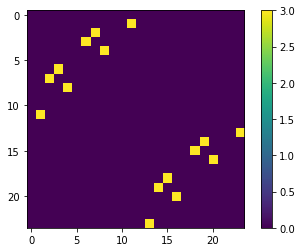

In [6]:
plt.imshow(adj_matrix)
plt.colorbar()
plt.show()

#### Define the target Hamiltonian

In [ ]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)


print(twobody_matrix)

#%% initialize the FH Hamiltonian



In [105]:
print(len(list(twobody_matrix.keys())))

print(np.average(np.abs(np.asarray(list(twobody_matrix.values())))))

16496
0.47885756477481256


In [ ]:
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
print('get the two body interaction...')
#TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
TargetHamiltonian.get_hamiltonian()

print('get the eigenvalue problem...')
egs,psi0=TargetHamiltonian.get_spectrum(n_states=1)

print(egs)

print(TargetHamiltonian.twobody_operator)



Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)



#### Create the interpolate Hamiltonian and Perform the spectrum

100%|██████████| 100/100 [00:10<00:00,  9.23it/s]


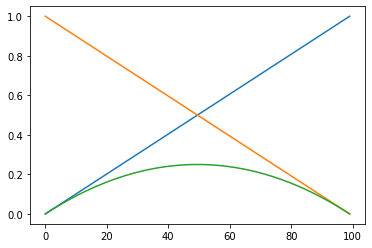

In [103]:
ngrid=100
nlevels=8
lambd=np.linspace(0,1.,ngrid)

spectrum=np.zeros((nlevels,ngrid))
psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
j_values=np.zeros_like(spectrum)
m_values = np.zeros_like(spectrum)

plt.plot(lambd)
plt.plot(1-lambd)
plt.plot(lambd*(1-lambd))

for i in trange(ngrid):

    ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

    values,psis=eigsh(ham,k=8,which='SA')
    for a in range(psis.shape[-1]):    
        #j_values[a,i]=psis[:,a].conjugate() @ Joperator.hamiltonian @ psis[:,a]
        m_values[a, i] = SPS.compute_m_exp_value(psi=psis[:,a],basis=InitialHamiltonian.basis)

    spectrum[:,i]=values
    psi_spectrum=psis

Spectrum

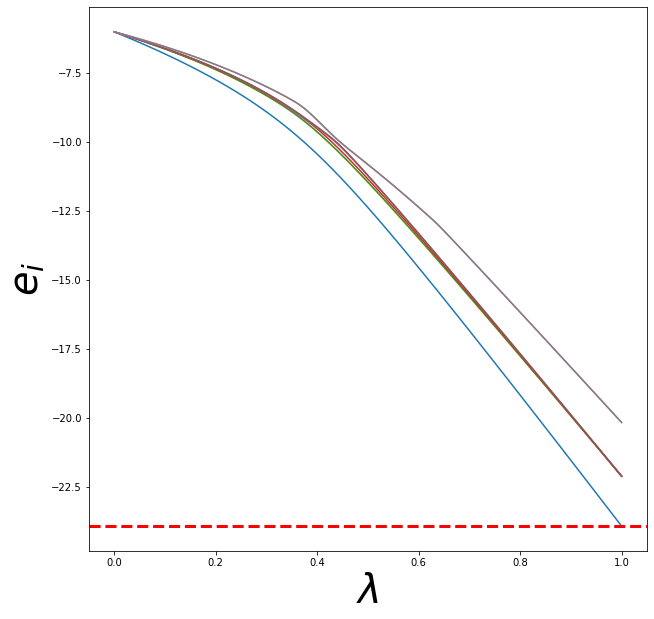

1.262177448353619e-29
-23.93429270827922


In [104]:
plt.figure(figsize=(10,10))
for i in range(nlevels):
    plt.plot(lambd,spectrum[i])
# plt.xlim([0.9,1])
plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)
plt.savefig('images/o18_spectrum')
plt.show()


t_critic=np.argmax(spectrum[0])
gap=np.min(np.abs(spectrum[1,:]-spectrum[0,:]))
print((gap**2))
print(spectrum[0,-1])

#### Expectation values

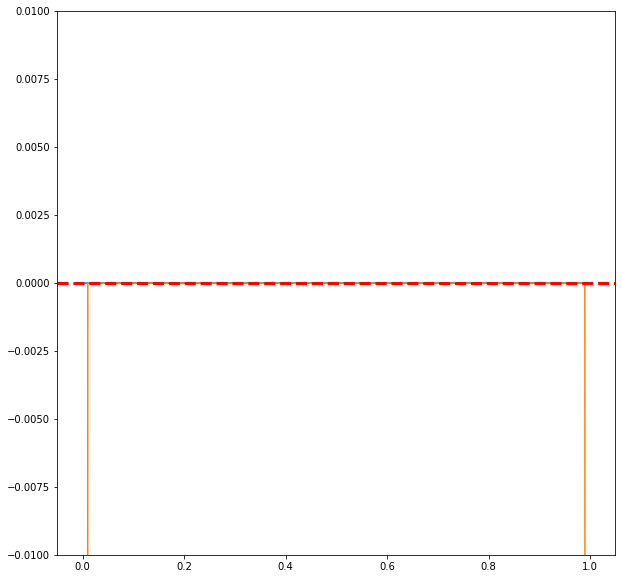

In [80]:



plt.figure(figsize=(10, 10))
for i in range(2):
    plt.plot(lambd, m_values[i])
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
plt.ylim([-0.01,0.01])
# plt.xlim([0.9,1])
plt.show()

#### Simulation of the Quantum Annealing

In [81]:
nstep =50
tf = 10
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
probabilities=np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=8, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])
            count=count+1
    
        probabilities[j,i]=(
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_598563/640188158.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  probabilities[j,i]=(
100%|██████████| 50/50 [00:01<00:00, 36.15it/s]

[0.01788904]
(0.9033846572897127+0j)


(50,)


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

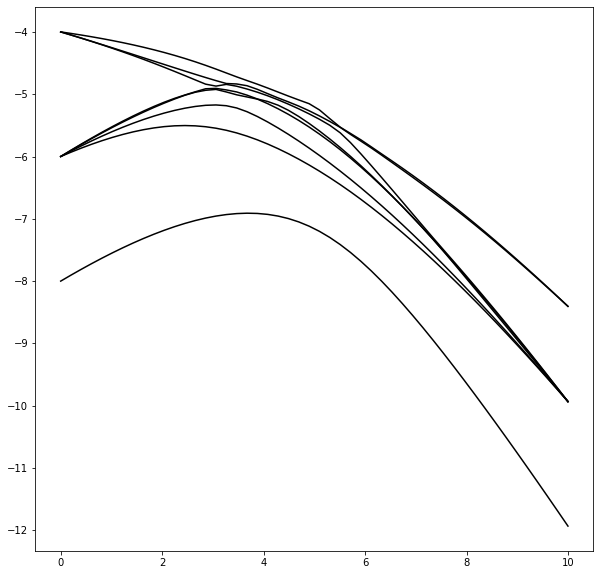

In [60]:
print(eng_t.shape)
plt.figure(figsize=(10, 10))
for i in range(nlevels):
    plt.plot(time, spectrum[i],color='black')


plt.plot(time,eng_t[:,0,0],color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=0,y=0,s=r'$F(t_f)=$'+f'{fidelity.real:.3f}',fontsize=30)
# plt.text(x=tf * 2 / 5, y=-22, s=r"$T_f=$" + f"{tf:.1f} 1/J, h1 strategy", fontsize=30)
plt.text(x=0, y=-2, s=r"$\Delta_r e=$" + f"{(eng_t[-1,0,0].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=0,
    y=-4,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/o18_qa_m_conservation')
plt.show()


plt.plot(time, variance_t[:, 0, 0], color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$\sigma_e$", fontsize=40)
plt.show()

plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)
plt.savefig('images/o18_fidelity_m_conservation')
plt.show()

### Gap VS hopping term

#### Imports

In [ ]:

from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

file_name='data/cki'
SPS=SingleParticleState(file_name=file_name)

In [ ]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

#### Define the target Hamiltonian

In [ ]:
twobody_matrix,matrix_j,matrix_m,energies=get_twobody_nuclearshell_model(file_name=file_name)


print(twobody_matrix)

#%% initialize the FH Hamiltonian



In [ ]:
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.get_hamiltonian()

egs,psi0=TargetHamiltonian.get_spectrum(n_states=1)

print(egs)

print(TargetHamiltonian.twobody_operator)


Joperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Joperator.get_twobody_interaction(twobody_dict=matrix_j)
Joperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Moperator.get_twobody_interaction(twobody_dict=matrix_m)
Moperator.get_hamiltonian()

#### Create the interpolate Hamiltonian and Perform the spectrum

In [ ]:
hs=np.linspace(-10,10,10)
gs=np.linspace(-10,10,10)

gap=np.zeros((10,10))
min_lambd=np.ones_like(hs)

for r,h in enumerate(hs):
    for q,g in enumerate(gs):

        t=3.
        
        InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

        kinetic_term:Dict={}
        adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

        #cki
        j_values=[1/2,3/2]




        mj_list=[]
        for j in j_values:
            m_values=-2*j+2*np.arange(0,int(2*j)+1)
            
            m_values=m_values[m_values>0.]
            for m in m_values:
                mj_list.append((m/2,j,1))


        # for tzi in [-1/2,1/2]:
            
        #     for tupi in mj_list:
        #         for tupj in mj_list:
        #             mi,ji=tupi
        #             mj,jj=tupj
                    
        #             i=SPS.get_index((1,0,ji,mi,1/2,tzi))
        #             k=SPS.get_index((1,0,ji,-1*mi,1/2,tzi))
        #             j=SPS.get_index((1,0,jj,mj,1/2,tzi))
        #             l=SPS.get_index((1,0,jj,-1*mj,1/2,tzi))
        #             kinetic_term[(i,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        #             adj_matrix[i,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                    
        #             kinetic_term[(i,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        #             adj_matrix[i,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                    
        #             kinetic_term[(k,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        #             adj_matrix[k,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                    
        #             kinetic_term[(k,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        #             adj_matrix[k,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        for tzi in [-1/2,1/2]:
            
            for f,tupi in enumerate(mj_list):
                mi,ji,ni=tupi
                mj,jj,nj=mj_list[(f+1)% len(mj_list)]
                
                #if ni==nj:
                i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
                k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
                j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
                l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
                kinetic_term[(i,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[i,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                kinetic_term[(j,i)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[j,i]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
                kinetic_term[(i,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[i,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                kinetic_term[(l,i)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[l,i]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
                kinetic_term[(k,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[k,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                kinetic_term[(j,k)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[j,k]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
                kinetic_term[(k,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[k,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
                kinetic_term[(l,k)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[l,k]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
                kinetic_term[(i,k)]=(h*(ji)+g*np.abs(mi))/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[i,k]=(h*(ji)+g*np.abs(mi))/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
                kinetic_term[(k,i)]=(h*(ji)+g*np.abs(mi))/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[k,i]=(h*(ji)+g*np.abs(mi))/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
            for f,tupi in enumerate(mj_list):
                mi,ji,ni=tupi
                mj,jj,nj=mj_list[(f-1)% len(mj_list)]
                
                #if ni==nj:
                i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
                k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
                j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
                l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
                kinetic_term[(i,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[i,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                kinetic_term[(j,i)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[j,i]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
                kinetic_term[(i,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[i,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                kinetic_term[(l,i)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[l,i]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
                kinetic_term[(k,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[k,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                kinetic_term[(j,k)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[j,k]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
                kinetic_term[(k,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[k,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
                kinetic_term[(l,k)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[l,k]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
                
                # for f,tupi in enumerate(mj_list):
                #     mi,ji,ni=tupi
                #     rand=np.random.uniform(0,0.3)
                    
                #     #if ni==nj:
                #     i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
                #     j=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
                    
                #     kinetic_term[(i,j)]=h*(ji+rand)/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                #     adj_matrix[i,j]=h**(ji+rand)/2#np.abs(mi-mj)#+np.abs(ji-jj)
                #     kinetic_term[(j,i)]=h**(ji+rand)/2 #np.abs(mi-mj)#+np.abs(ji-jj)
                #     adj_matrix[j,i]=h**(ji+rand)/2#np.abs(mi-mj)#+np.abs(ji-jj)
                    
                    
                    
                
            # for f,tupi in enumerate(mj_list):
            #     mi,ji,ni=tupi
            #     mj,jj,nj=tupi
            #     #if ni==nj:
            #     i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
            #     k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
            #     j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
            #     l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
            #     kinetic_term[(i,j)]=t_diag/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            #     adj_matrix[i,j]=t_diag/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
            #     kinetic_term[(i,l)]=t_diag/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            #     adj_matrix[i,l]=t_diag/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
            #     kinetic_term[(k,j)]=t_diag/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            #     adj_matrix[k,j]=t_diag/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
            #     kinetic_term[(k,l)]=t_diag/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            #     adj_matrix[k,l]=t_diag/2#np.abs(mi-mj)#+np.abs(ji-jj)


        # # for i in range(size_a):
        # #     for j in range(size_a):
        # #         (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
        # #         (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
        # #         if np.isclose(mi,-mj) and np.isclose(ni,nj):
                    
        # #             if size_b==size_a:    
        # #                 kinetic_term[(size_a +i,size_a+j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                        
        external_field=np.zeros(size_a+size_b)
        rand=np.random.uniform(0,1,3)
        rand_dict={1/2:rand[0],-1/2:rand[1]}
        for i in range(size_a+size_b):
            (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
            j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
            external_field[i]=h*(ji)+g*np.abs(mi)

            
            #external_field[i] = SPS.energies[i]


        InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
        InitialHamiltonian.get_external_potential(external_field)
        InitialHamiltonian.get_hamiltonian()

        einitial,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)
        ngrid=100
        nlevels=8
        lambd=np.linspace(0,1.,ngrid)

        spectrum=np.zeros((nlevels,ngrid))
        psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
        j_values=np.zeros_like(spectrum)
        m_values = np.zeros_like(spectrum)

        plt.plot(lambd)
        plt.plot(1-lambd)
        plt.plot(lambd*(1-lambd))

        for i in trange(ngrid):

            ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

            values,psis=eigsh(ham,k=8,which='SA')
            for a in range(psis.shape[-1]):    
                j_values[a,i]=psis[:,a].conjugate() @ Joperator.hamiltonian @ psis[:,a]
                m_values[a, i] = psis[:, a].conjugate() @ Moperator.hamiltonian @ psis[:, a]

            spectrum[:,i]=values
            psi_spectrum=psis
            
        gap[r,q]=np.min(spectrum[1]-spectrum[0])
        #min_lambd[r]=np.argmin(np.min(spectrum[1]-spectrum[0]))

#### GAP VS t

In [ ]:
plt.figure(figsize=(10, 10))
plt.xlabel(r'$h$',fontsize=40)
plt.xticks(np.arange(gs.shape[0]),gs)
print(gs)
plt.yticks(np.arange(gs.shape[0]),hs)
plt.ylabel(r'$g$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.imshow(gap)
plt.colorbar()
plt.savefig('images/be10_gap_hopping_term')
plt.show()



#### Simulation of the Quantum Annealing

In [ ]:
nstep =1000
tf = 30
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=8, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:, 0]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:, 0])
            count=count+1

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)

In [ ]:
print(eng_t.shape)
plt.figure(figsize=(10, 10))
for i in range(nlevels):
    plt.plot(time, spectrum[i],color='black')


plt.plot(time,eng_t[:,0,0],color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=tf*2/5,y=-20,s=r'$F(t_f)=$'+f'{fidelity.real:.3f}',fontsize=30)
# plt.text(x=tf * 2 / 5, y=-22, s=r"$T_f=$" + f"{tf:.1f} 1/J, h1 strategy", fontsize=30)
plt.text(x=tf * 2 / 5, y=-22, s=r"$\Delta_r e=$" + f"{(eng_t[-1,0,0].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=tf * 2 / 5,
    y=-24,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/be10_qa')
plt.show()


plt.plot(time, variance_t[:, 0, 0], color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$\sigma_e$", fontsize=40)
plt.show()

plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)
plt.savefig('images/be10_fidelity')
plt.show()

In [ ]:
nstep =1000
tf = 30
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=8, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:, 0]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:, 0])
            count=count+1

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)

In [ ]:
print(eng_t.shape)
plt.figure(figsize=(10, 10))
for i in range(nlevels):
    plt.plot(time, spectrum[i],color='black')


plt.plot(time,eng_t[:,0,0],color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=tf*2/5,y=-20,s=r'$F(t_f)=$'+f'{fidelity.real:.3f}',fontsize=30)
# plt.text(x=tf * 2 / 5, y=-22, s=r"$T_f=$" + f"{tf:.1f} 1/J, h1 strategy", fontsize=30)
plt.text(x=tf * 2 / 5, y=-22, s=r"$\Delta_r e=$" + f"{(eng_t[-1,0,0].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=tf * 2 / 5,
    y=-24,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/be10_qa')
plt.show()


plt.plot(time, variance_t[:, 0, 0], color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$\sigma_e$", fontsize=40)
plt.show()

plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)
plt.savefig('images/be10_fidelity')
plt.show()